In [1]:
import argparse
import json
import logging
import pickle
import random
import time
from copy import deepcopy
from dataclasses import dataclass, field, fields
from datetime import datetime, timedelta, timezone
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import yaml
from pathos.multiprocessing import ProcessingPool as Pool
from sbi.inference import NPE
from sbi.utils import BoxUniform, RestrictedPrior, get_density_thresholder
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_simulator,
)
from simglucose.actuator.pump import InsulinPump
from simglucose.controller.basal_bolus_ctrller import BBController
from simglucose.patient.t1dpatient import T1DPatient
from simglucose.sensor.cgm import CGMSensor
from simglucose.simulation.env import T1DSimEnv
from simglucose.simulation.scenario import CustomScenario
from simglucose.simulation.sim_engine import SimObj
from sklearn.metrics import mean_squared_error
from torch.distributions import Distribution
from tqdm import tqdm


In [2]:
pathos = True

In [3]:
@dataclass
class DeafultSimulationEnv:
    """Dataclass for the default simulation environment."""

    patient_name: str | None = None
    sensor_name: str | None = None
    pump_name: str | None = None
    scenario: list[tuple[int, int]] = field(default_factory=list)
    hours: int = 24  # hours to simulate

In [5]:
@dataclass
class ParamPriors:
    """Dataclass for the prior distributions of the model parameters."""

    x0_10: tuple[float, float] | None = None
    x0_11: tuple[float, float] | None = None
    x0_12: tuple[float, float] | None = None
    x0_13: tuple[float, float] | None = None
    BW: tuple[float, float] | None = None
    EGPb: tuple[float, float] | None = None
    Gb: tuple[float, float] | None = None
    Ib: tuple[float, float] | None = None
    kabs: tuple[float, float] | None = None
    kmax: tuple[float, float] | None = None
    kmin: tuple[float, float] | None = None
    b: tuple[float, float] | None = None
    d: tuple[float, float] | None = None
    Vg: tuple[float, float] | None = None
    Vi: tuple[float, float] | None = None
    Ipb: tuple[float, float] | None = None
    Vmx: tuple[float, float] | None = None
    Km0: tuple[float, float] | None = None
    k2: tuple[float, float] | None = None
    k1: tuple[float, float] | None = None
    p2u: tuple[float, float] | None = None
    m1: tuple[float, float] | None = None
    m5: tuple[float, float] | None = None
    CL: tuple[float, float] | None = None
    HEb: tuple[float, float] | None = None
    m2: tuple[float, float] | None = None
    m4: tuple[float, float] | None = None
    m30: tuple[float, float] | None = None
    Ilb: tuple[float, float] | None = None
    ki: tuple[float, float] | None = None
    kp2: tuple[float, float] | None = None
    kp3: tuple[float, float] | None = None
    Gpb: tuple[float, float] | None = None
    Gtb: tuple[float, float] | None = None
    Vm0: tuple[float, float] | None = None
    Rdb: tuple[float, float] | None = None
    PCRb: tuple[float, float] | None = None
    kd: tuple[float, float] | None = None
    ksc: tuple[float, float] | None = None
    ka1: tuple[float, float] | None = None
    ka2: tuple[float, float] | None = None
    u2ss: tuple[float, float] | None = None
    isc1ss: tuple[float, float] | None = None
    isc2ss: tuple[float, float] | None = None
    kp1: tuple[float, float] | None = None

print("Number of parameters:", len(fields(ParamPriors)))

Number of parameters: 45


In [6]:
def set_up_logging() -> logging.Logger:
    """Set up the logging configuration for the script."""
    logger = logging.getLogger("script_logger")
    logger.setLevel(logging.INFO)
    handler = logging.FileHandler("infer_parameters.log")
    formatter = logging.Formatter(
        "%(asctime)s - %(levelname)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S"
    )
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    return logger

In [8]:
script_logger = set_up_logging()

In [9]:
def load_config(config_name: "str") -> dict:
    """Loads the configuration file.

    Parameters
    ----------
    config_name : str
        The name of the configuration file to load.

    Returns
    -------
    dict
        The configuration file as a dictionary.

    """
    with Path(f"simulation_configs/{config_name}").open() as file:
        script_logger.info("Loaded configuration file: %s", config_name)
        return yaml.safe_load(file)

In [10]:
def set_up_device() -> torch.device:
    """Set up the device for the simulation."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    script_logger.info("Device used for execution: %s", device)
    return device

In [12]:
device = set_up_device()
print("device:", device)

device: cpu


In [13]:
def set_up_pathos() -> bool:
    """Set up pathos for multiprocessing."""
    try:
        pathos = True
        script_logger.info("Pathos enabled for multiprocessing")
    except ImportError:
        script_logger.warning("Pathos not enabled")
        pathos = False
    return pathos


In [14]:
def select_random_parameters(
    param_priors: dict[str, tuple[float, float]], num_params: int
) -> dict[str, tuple[float, float]]:
    """Select a specified number of random parameters from the parameter priors.

    Parameters
    ----------
    param_priors : Dict[str, Any]
        The parameter priors as a dictionary.
    num_params : int
        The number of random parameters to select.

    Returns
    -------
    Dict[str, Any]
        A dictionary containing the selected random parameters.

    """
    if num_params >= len(param_priors):
        return param_priors
    selected_keys = random.sample(list(param_priors.keys()), num_params)
    return {key: param_priors[key] for key in selected_keys}

In [15]:
def get_patient_params(env: T1DSimEnv, priors: ParamPriors) -> dict:
    """Returns the patient parameters that were used in the simulation.

    Parameters
    ----------
    env : T1DSimEnv
        simglucose simulation environment
    priors : ParamPriors
        dataclass containing the priors for the patient parameters
        (we only want to look at the parameters that are being inferred)

    Returns
    -------
    dict
        dictionary containing the patient parameters used in the simulation

    """
    param_names = [f.name for f in fields(priors)]
    params = [
        getattr(env.env.patient._params, param)  # noqa: SLF001
        for param in param_names
    ]
    return dict(zip(param_names, params))

In [16]:
def process_uniform_priors(priors: ParamPriors, device: torch.device) -> Distribution:
    """Converts the priors to a single 23D BoxUniform distribution.

    Parameters
    ----------
    priors : ParamPriors
        Uniform prior distributions for the model parameters
    device : torch.device
        The device to use for the simulation

    Returns
    -------
    Distribution
        23D torch BoxUniform distribution

    """
    low_vals = []
    high_vals = []
    for f in fields(priors):
        # get the value for the field
        value = getattr(priors, f.name)
        if value is None:
            continue

        low, high = getattr(priors, f.name)
        low_vals.append(low)
        high_vals.append(high)

    low_tensor = torch.tensor(low_vals, dtype=torch.float32, device=device)
    high_tensor = torch.tensor(high_vals, dtype=torch.float32, device=device)

    return BoxUniform(low=low_tensor, high=high_tensor, device=device)

In [17]:
def load_default_simulation_env(
    env_settings: DeafultSimulationEnv, hours: int = 24
) -> T1DSimEnv:
    """Load the default simulation environment.

    Parameters
    ----------
    env_settings : DeafultSimulationEnv
        DataClass object containing the default simulation environment settings.
    hours : int, optional
        The number of hours to simulate, by default 24

    Returns
    -------
    T1DSimEnv
        The simulation environment object.

    """
    now = datetime.now(tz=timezone.utc)
    start_time = datetime.combine(now.date(), datetime.min.time())

    patient = T1DPatient.withName(env_settings.patient_name)
    sensor = CGMSensor.withName(env_settings.sensor_name, seed=1)
    pump = InsulinPump.withName(env_settings.pump_name)
    scenario = CustomScenario(start_time=start_time, scenario=env_settings.scenario)
    controller = BBController()
    env = T1DSimEnv(patient=patient, sensor=sensor, pump=pump, scenario=scenario)

    return SimObj(
        env=env, controller=controller, sim_time=timedelta(hours=hours), animate=False
    )

In [18]:
def set_custom_params(
    patient: T1DPatient, custom_params: torch.Tensor, priors: ParamPriors
) -> None:
    """Apply the custom parameters (used for a particular simulation) for the patient.

    Parameters
    ----------
    patient : T1DPatient
        The patient object
    custom_params : torch.Tensor
        The custom parameters to apply to the patient
    priors : ParamPriors
        The priors for the parameters
        (we need only the names of the parameters that will actually be used in the simulation)

    """
    # convert tensor to list
    custom_params = custom_params.tolist()

    param_names = [
        field.name for field in fields(priors) if getattr(priors, field.name)
    ]
    for i, param in enumerate(param_names):
        setattr(patient._params, param, custom_params[i])  # noqa: SLF001

In [19]:
def create_simulation_envs_with_custom_params(
    params_sets: torch.Tensor,
    default_settings: DeafultSimulationEnv,
    priors: ParamPriors,
    hours: int = 24,
) -> list[T1DSimEnv]:
    """Creates a list of simulation environments with custom parameters.

    Parameters
    ----------
    params_sets : torch.Tensor
        Sets of custom parameters to use for the simulation of shape (N_sets, N_params)
    default_settings : DeafultSimulationEnv
        DataClass object containing the default simulation environment settings.
    priors : ParamPriors
        DataClass object containing the priors for the parameters
    hours : int, optional
        Duration of simulation, by default 24

    Returns
    -------
    list[T1DSimEnv]
        List of simulation environments with custom parameters

    """
    default_simulation_env = load_default_simulation_env(
        hours=hours, env_settings=default_settings
    )
    simulation_envs = []
    for i in range(params_sets.shape[0]):
        custom_sim_env = deepcopy(default_simulation_env)
        # row i is shape (23,)
        set_custom_params(custom_sim_env.env.patient, params_sets[i], priors)
        simulation_envs.append(custom_sim_env)
    return simulation_envs

In [20]:
def simulate_glucose_dynamics(simulation_env: T1DSimEnv) -> np.ndarray:
    """Simulates the glucose dynamics for a given simulation environment.

    Parameters
    ----------
    simulation_env : T1DSimEnv
        The simulation environment object

    Returns
    -------
    np.ndarray
        The glucose dynamics

    """
    simulation_env.simulate()
    return simulation_env.results()["CGM"].to_numpy()

In [21]:
def simulate_batch(simulations: list[T1DSimEnv], device: torch.device) -> torch.Tensor:
    """Simulate a batch of simulation environments in parallel.

    Parameters
    ----------
    simulations : list[T1DSimEnv]
        List of simulation environments
    device : torch.device
        The device to use for the simulation

    Returns
    -------
    torch.Tensor
        The glucose dynamics for each simulation

    """
    tic = time.time()

    pathos = True
    if pathos:
        with Pool() as p:
            logging.info("Using pathos for multiprocessing")
            results = p.map(simulate_glucose_dynamics, simulations)
    else:
        results = [simulate_glucose_dynamics(s) for s in tqdm(simulations)]
    toc = time.time()
    logging.info("Simulation took %s sec.", toc - tic)
    results = np.stack(results)
    return torch.from_numpy(results).float().to(device)

In [22]:
def run_glucose_simulator(
    params_sets: torch.Tensor,
    default_settings: DeafultSimulationEnv,
    priors: ParamPriors,
    device: torch.device,
    hours: int = 24,
) -> torch.Tensor:
    """Run the glucose simulator for a batch of custom parameters.

    Parameters
    ----------
    params_sets : torch.Tensor
        Sets of custom parameters to use for the simulation of shape (N_sets, N_params)
    default_settings : DeafultSimulationEnv
        DataClass object containing the default simulation environment settings.
    priors : ParamPriors
        DataClass object containing the priors for the parameters
    hours : int, optional
        Duration of the simulation, by default 24
    device : torch.device, optional
        Device used to run the simulation, by default torch.device('cpu')

    Returns
    -------
    torch.Tensor
        The glucose dynamics time series for each simulation

    """
    # Suppose params_sets is (N, 23)
    simulation_envs = create_simulation_envs_with_custom_params(
        params_sets=params_sets,
        default_settings=default_settings,
        priors=priors,
        hours=hours,
    )
    return simulate_batch(simulation_envs, device)

In [42]:
def set_up_sbi_simulator(
    default_settings: DeafultSimulationEnv,
    priors: ParamPriors,
    device: torch.device,
    glucose_simulator: callable = run_glucose_simulator,
    processed_priors: Distribution | None = None,
) -> callable:
    """Sets up and checks the simulator for the Sequential Bayesian Inference (SBI) framework.

    Parameters
    ----------
    default_settings : DeafultSimulationEnv
        DataClass object containing the default simulation environment settings.
    priors : ParamPriors
        DataClass object containing the priors for the parameters
    device : torch.device
        Device used to run the simulation
    glucose_simulator : callable, optional
        Function that runs the glucose simulator, by default run_glucose_simulator

    Returns
    -------
    callable
        The SBI simulator function used to infer the parameters

    """
    set_up_glucose_simulator = partial(
        glucose_simulator,
        default_settings=default_settings,
        priors=priors,
        device=device,
    )
    if not processed_priors:
        processed_priors = process_uniform_priors(
            priors=priors, device=device
        )  # N-D BoxUniform

    script_logger.info("Prior of shape: %s", processed_priors.event_shape)
    sbi_sumulator = process_simulator(
        set_up_glucose_simulator, processed_priors, is_numpy_simulator=True
    )
    check_sbi_inputs(sbi_sumulator, processed_priors)  # optional
    return sbi_sumulator

In [24]:
def get_true_observation(
    priors: ParamPriors, env_settings: DeafultSimulationEnv, hours: int = 24
) -> tuple[torch.Tensor, dict]:
    """Returns the single glucose dynamcis simulation from the default simulation environment parameters and these parameters.

    Parameters
    ----------
    priors : ParamPriors
        DataClass object containing the priors for the parameters
    env_settings : DeafultSimulationEnv
        DataClass object containing the default simulation environment settings.
    hours : int, optional
        Duration of the simulation, by default 24

    Returns
    -------
    np.ndarray
        Time series of glucose dynamics.

    """
    default_simulation_env = load_default_simulation_env(
        env_settings=env_settings, hours=hours
    )
    default_simulation_env.simulate()
    true_params = get_patient_params(default_simulation_env, priors)
    true_observation = default_simulation_env.results()["CGM"].to_numpy()
    true_observation = torch.from_numpy(true_observation).float().to(device)
    return true_observation, true_params

In [25]:
def sample_from_posterior(
    posterior: Distribution, x_true: np.ndarray, num_samples: int = 1000
) -> torch.Tensor:
    """Sample from the posterior distribution.

    Parameters
    ----------
    posterior : Distribution
        The posterior distribution of the parameters.
    x_true : np.ndarray
        The true observation to compare the inference results to.
    num_samples : int, optional
        number of required samples, by default 1000

    Returns
    -------
    torch.Tensor
        The posterior samples.

    """
    x_true = torch.tensor(x_true, dtype=torch.float32, device=device)
    return posterior.sample((num_samples,), x=x_true)

In [75]:
def sample_positive(proposal, num_samples):
    """Sample from the multivariate normal distribution and constrain samples to be positive.

    Parameters
    ----------
    proposal : MultivariateNormal
        The multivariate normal distribution to sample from.
    num_samples : int
        The number of positive samples to obtain.

    Returns
    -------
    torch.Tensor
        A tensor containing the positive samples.
    """
    positive_samples = []
    while len(positive_samples) < num_samples:
        sample = proposal.sample()
        if torch.all(sample > 0):
            positive_samples.append(sample)
    return torch.stack(positive_samples)

In [76]:
def run_tsnpe(
    prior: Distribution,
    simulator: callable,
    true_observation: torch.Tensor,
    device: torch.device,
    num_rounds: int = 10,
    num_simulations: int = 1000,
) -> Distribution:
    """Runs the Truncated Sequential Neural Posterior Estimation (TSNPE) algorithm.

    Parameters
    ----------
    prior : torch.distributions.Distribution
        The prior distribution for the parameters to infer.
    simulator : callable
        The simulator function that generates the data.
    true_observation : torch.Tensor
        The true observation to compare the inference results to.
    device : torch.device
        The device to use for the simulation.
    num_rounds : int, optional
        number  of inference rounds, by default 10
    num_simulations : int, optional
        number of simulations per inferenceround, by default 1000

    Returns
    -------
    Distribution
        The posterior distribution of the parameters.

    """
    inference = NPE(prior=prior, device=device)
    proposal = prior
    for _ in range(num_rounds):
        theta = sample_positive(proposal, num_simulations)
        x = simulator(theta)

        # Optional sanity check: ensure on same device
        theta = theta.to(device)
        x = x.to(device)

        _ = inference.append_simulations(theta, x).train(force_first_round_loss=True)
        posterior = inference.build_posterior().set_default_x(true_observation)

        accept_reject_fn = get_density_thresholder(posterior, quantile=1e-4)
        proposal = RestrictedPrior(
            prior,
            accept_reject_fn,
            sample_with="rejection",
            device=device,
        )
        save_acceptance_rate = proposal.acceptance_rate
        print(f"Acceptance rate: {save_acceptance_rate}")
    return posterior

In [27]:
def run_apt(
    prior: Distribution,
    simulator: callable,
    true_observation: torch.Tensor,
    device: torch.device,
    num_rounds: int = 10,
    num_simulations: int = 1000,
) -> Distribution:
    """Runs the Automatic Posterior Transformation (APT) NPE algorithm.

    Parameters
    ----------
    prior : Distribution
        The prior distribution for the parameters to infer.
    simulator : callable
        The simulator function that generates the data.
    true_observation : torch.Tensor
        The true observation to compare the inference results to.
    device : torch.device
        The device to use for the simulation.
    num_rounds : int, optional
        number of inference rounds, by default 10
    num_simulations : int, optional
        number of simulations per inference round, by default 1000

    Returns
    -------
    Distribution
        The posterior distribution of the parameters.

    """
    # Initialize NPE on device
    inference = NPE(prior=prior, device=device)

    proposal = prior  # start with prior

    for r in range(num_rounds):
        script_logger.info("Running round %s of %s", r + 1, num_rounds)

        theta = proposal.sample((num_simulations,))
        x = simulator(theta)
        theta = theta.to(device)
        x = x.to(device)

        _ = inference.append_simulations(theta, x, proposal=proposal).train()

        posterior_dist = inference.build_posterior().set_default_x(true_observation)

        proposal = posterior_dist

    return posterior_dist

In [28]:
def run_npe(
    algorithm: str, priors: ParamPriors, device: torch.device, **kwargs: dict
) -> Distribution:
    """Run the specified NPE algorithm.

    Parameters
    ----------
    algorithm : str
        The name of the NPE algorithm to run.
    priors : ParamPriors
        DataClass object containing the priors for the parameters.
    device : torch.device
        The device to use for the simulation.
    **kwargs : dict
        Additional keyword arguments for the NPE algorithm.

    Returns
    -------
    Distribution
        The posterior distribution of the parameters.

    """
    processed_prior = process_uniform_priors(priors=priors, device=device)
    if algorithm == "TSNPE":
        return run_tsnpe(prior=processed_prior, device=device, **kwargs)
    if algorithm == "APT":
        return run_apt(prior=processed_prior, device=device, **kwargs)
    msg = f"Invalid NPE algorithm: {algorithm}"
    raise ValueError(msg)

In [33]:
default_settings = DeafultSimulationEnv(
    patient_name="adolescent#001",
    sensor_name="Dexcom",
    pump_name="Insulet",
    scenario=[(7,45),(12,70),(16,15),(18,80), (23,10)],
    hours=24,
)

In [36]:
param_dict = json.load(open("param_dict.json", "r"))
print(len(param_dict))

45


In [32]:
priors = ParamPriors(**param_dict)

In [34]:
true_observation, true_params = get_true_observation(
        priors=priors, env_settings=default_settings, hours=24
    )

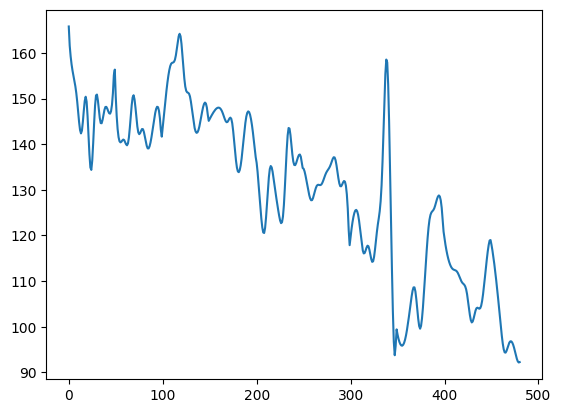

In [35]:
plt.plot(true_observation.to("cpu").numpy())

In [40]:
mv_normal_prior = pickle.load(open("mvn_prior.pkl", "rb"))
print(type(mv_normal_prior))
print(isinstance(mv_normal_prior, torch.distributions.Distribution))

<class 'torch.distributions.multivariate_normal.MultivariateNormal'>
True


In [ ]:
sbi_simulator = set_up_sbi_simulator(default_settings=default_settings, priors=priors, device=device, processed_priors=mv_normal_prior)

In [66]:
post = run_tsnpe(prior=mv_normal_prior, simulator=sbi_simulator, true_observation=true_observation, device=device, num_rounds=1, num_simulations=1000)